In [1]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

import bo_methods_lib
from bo_methods_lib.CS2_create_data import calc_muller, create_sse_data, create_y_data, calc_y_exp

#Note: Need to normalize all values

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
#Change this to get less parameters
# Create synthetic data assuming the following values for theta
# a_guess = np.array([-150,-75,-150,10, #A guess
#                     0.5,0.5,-7,1, #a guess
#                     -1, 1, 10, 1,#b guess
#                     -8, -8, -8, 0,#c guess
#                     0.5, 0.5, 0, 0,#x0 guess
#                     0.5, 0.5, 0.5, 0.5]) #y0 guess

# a_guess = np.array([-150,-75,-150,10, #A guess
#                     0.5,0.5,-7,1, #a guess
#                     -1, 1, 10, 1,#b guess
#                     -8, -8, -8, 0,#c guess
#                     0.5, 0.5, 0, 0]) #x0 guess

a_guess = np.array([0.5,0.5,-7,1, #a guess
                    -1, 1, 10, 1]) #b guess

# a_guess = np.array([-1, 1, 10, 1]) #b guess

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])

skip_params = 1

num_param_guess = int(len(a_guess)/Constants.shape[1])
##New Cell
# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
n = 15 # 2.1 = 5, 2.2 = 15, 2.3 = 20, 2.4 = 25, 2.5 = 30, 2.6 = 30
exp_data_doc = "Input_CSVs/Exp_Data/n="+str(n)+".csv"
exp_data = pd.read_csv(exp_data_doc, header=0,sep=",",index_col=0)
Num_params  = len(exp_data.T)
Xexp = np.array([exp_data.iloc[:,0:Num_params-1]])[0,:]
Yexp = np.array([exp_data.iloc[:,-1]])[0,:]
# print(Xexp)
print(a_guess[0])
print(Constants.shape)

0.5
(6, 4)
CPU times: user 6.54 ms, sys: 4.01 ms, total: 10.6 ms
Wall time: 9.93 ms


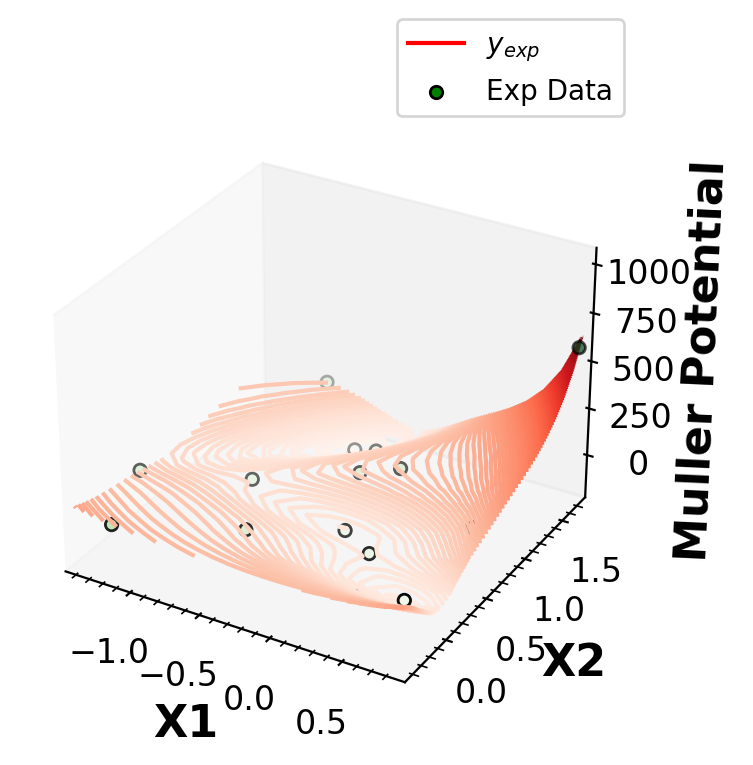

In [3]:
##New Cell

# Evaluate model based on the assumed experimental values
#Create Meshgrid for X1 and X2 and evaluate Y
len_mesh_data = 20
x1 = np.linspace(np.min(Xexp[:,0]),np.max(Xexp[:,0]),len_mesh_data)
x2 = np.linspace(np.min(Xexp[:,1]),np.max(Xexp[:,1]),len_mesh_data)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
# #Creates an array for Y that will be filled with the for loop
# #Initialize y_sim
Y = [] #len_data 

# #Find evey combination of X1/X2 to find the SSE for each combination
#Set constants
A, a, b, c, x0, y0 = Constants

#Calculate y_sim
#Define X1 and X2 (Need a better way do do this without for loops)
#Loop over combinations of X1 X2
for i in range(len_mesh_data):
    for j in range(len_mesh_data):
        Term1 = a*(X1[i,j] - x0)**2
        Term2 = b*(X1[i,j] - x0)*(X2[i,j] - y0)
        Term3 = c*(X2[i,j] - y0)**2
        Y.append( np.sum( A*np.exp(Term1 + Term2 + Term3) ) )
        
#Reshape to correct dimension (Is there an easier wat to do this?)        
Y = np.array(Y).reshape(len_mesh_data,-1)
# print(Y)
# Compare the experiments to the true model
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Y, 100, cmap='Reds')
ax.plot(1000,1000,1000, label = "$y_{exp}$", color = 'red')
ax.scatter(1000,1000,1000, label = "Exp Data", color = 'green', edgecolors = "k")
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens', edgecolors = "k")
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.0, 1, 0.2),borderaxespad=0, loc = "lower right")

ax.minorticks_on() # turn on minor ticks
ax.tick_params(direction="in",top=True, right=True) 
ax.tick_params(which="minor",direction="in",top=True, right=True)


ax.zaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.grid(False)

ax.set_xlim((np.amin(X1),np.amax(X1)))
ax.set_ylim((np.amin(X2),np.amax(X2)))

ax.set_xlabel('X1', fontsize=16,fontweight='bold')
ax.set_ylabel('X2', fontsize=16,fontweight='bold')
ax.set_zlabel('Muller Potential',fontsize=16,fontweight='bold');

ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='z', nbins=5)
# plt.title("Plotting True Model and Synthetic Data")
plt.show()

# Y_scaled = np.array(Y_scaled).reshape(len_mesh_data,-1)
# Y_bounds = np.array([np.min(Y_scaled), np.max(Y_scaled)])
# Y = values_scaled_to_real(Y_scaled, Y_bounds)
# Y = Y.reshape(len_mesh_data,-1)

In [4]:
##New Cell

## define function that includes nonlinear model
def model(a_guess, Constants, x, skip_params = 0):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Assert statements check that the types defined in the doctring are satisfied
    
    #Converts parameters to numpy arrays if they are tensors
    if torch.is_tensor(a_guess)==True:
        a_guess = a_guess.numpy()
        
    if isinstance(a_guess, pd.DataFrame):
        a_guess = a_guess.to_numpy()
    
    #Initialize y_sim, set len_data and dim_x
    len_x_shape = len(x.shape) #Will tell us whether we're looking at Xexp or Xmesh
        
    if len_x_shape < 3:
        len_x_data = x.shape[0]
        y_model = np.zeros(len_x_data)
        
    else:
        len_x_data = x.shape[1]
        y_model = np.zeros((len_x_data, len_x_data))
    
    #Set dig out values of a from train_p
    #Set constants to change the a row to the index of the first loop
    Constants_local = np.copy(Constants)
    dim_guess = int(len(a_guess)/Constants.shape[1])
    a_guess = a_guess.reshape(dim_guess,-1)
    
    for i in range(dim_guess):
        Constants_local[i+skip_params] = a_guess[i]#Since we've chosen A, a, b, c, x0, and y0
        
#     print(Constants_local)
#     print(Constants_local)
    A, a, b, c, x0, y0 = Constants_local
#     print(a,A)

    #Iterates over Xexp to find the y for each combination
    for i in range(len_x_data):
        #Calculate y_sim
        if len_x_shape < 3:
            X1, X2 = x[i,0], x[i,1]
            Term1 = a*(X1 - x0)**2
            Term2 = b*(X1 - x0)*(X2 - y0)
            Term3 = c*(X2 - y0)**2
            y_model[i] = np.sum(A*np.exp(Term1 + Term2 + Term3) )
        else:
        #loop over all i and j
            X1, X2 = x
            for i in range(len_x_data):
                for j in range(len_x_data):
                    Term1 = a*(X1[i,j] - x0)**2
                    Term2 = b*(X1[i,j] - x0)*(X2[i,j] - y0)
                    Term3 = c*(X2[i,j] - y0)**2
                    y_model[i,j] = ( np.sum( A*np.exp(Term1 + Term2 + Term3) ) )
   
    if not len_x_shape < 3:
        y_model = y_model.reshape(len_x_data, -1)
    
    return y_model

# print(model(a_guess,Constants,Xexp, skip_params))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(a_guess, Constants, x, y, skip_params = 0):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    
    error = y - model(a_guess, Constants, x, skip_params); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

# print(regression_func(a_guess, Constants, Xexp, Yexp))


In [5]:

## specify initial guess
a0 = a_guess
#Define # of dimensions
try:
    d = a_guess.shape[0]*a_guess.shape[1]
except:
    d = a_guess.shape[0]
## specify bounds
# first array: lower bounds
# second array: upper bounds
lower = np.repeat(-np.inf, d)
upper = np.repeat(np.inf, d)
bounds = (lower, upper) 

## use least squares optimizer in scipy
# argument 1: function that takes theta as input, returns residual
# argument 2: initial guess for theta
# optional arguments 'bounds': bounds for theta
# optional arugment 'args': additional arguments to pass to residual function
# optional argument 'method': select the numerical method
#   if you want to consider bounds, choose 'trf'
#   if you do not want to consider bounds, try either 'lm' or 'trf'
Solution = optimize.least_squares(regression_func, a0 ,bounds=bounds, method='trf',args=(Constants, Xexp, Yexp, skip_params),verbose=2)

a_model = Solution.x
a_model_soln = a_model.reshape(num_param_guess,-1)
print("a = ",a_model_soln)
print("Constants", Constants)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0047e+07                                    7.93e+07    
       1              3         1.5726e+06      8.47e+06       3.10e+00       1.12e+07    
       2              6         4.2993e+05      1.14e+06       3.87e-01       1.46e+06    
       3              7         9.9089e+04      3.31e+05       3.87e-01       3.48e+05    
       4              8         1.6067e+04      8.30e+04       7.74e-01       6.25e+04    
       5              9         2.2373e+03      1.38e+04       1.55e+00       9.47e+03    
       6             10         3.0002e+02      1.94e+03       2.98e+00       1.75e+03    
       7             11         4.4853e+01      2.55e+02       8.98e-01       3.05e+02    
       8             12         2.2735e+01      2.21e+01       1.30e+00       7.44e+01    
       9             14         1.6008e+01      6.73e+00       8.46e-01       3.91e+01    

In [6]:
# def sse_func(a_model, x, y, P_inds, P1_vals, P2_vals, skip_params):
def sse_func(a_model, x, y, meshgrid, P_inds, skip_params):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
#     #Meshgrid
#     P1_mesh, P2_mesh = np.meshgrid(P1_vals,P2_vals)
    xx, yy = meshgrid
    #Copy Center Point
    a_guess_local = np.copy(a_model)
    #Initialize SSE Maxtrix
    sse = np.zeros((xx.shape))
    
    #Calculate SSE
    for i in range(len(xx)):
        for j in range(len(yy)):
            a_guess_local[P_inds[0]+ 4*skip_params] = xx[i,j]
            a_guess_local[P_inds[1]+ 4*skip_params] = yy[i,j]
#             print(a_guess_local)
            sse[i,j] = sum((y - model(a_guess_local, Constants, x, skip_params))**2) 
    
    return sse

In [7]:
# a1, a2, a3, a4 = np.meshgrid(a1_lin, a2_lin, a3_lin, a4_lin)
# a_guesses = np.meshgrid(a1_lin, a2_lin, a3_lin, a4_lin)

# P_inds = np.array([0,3])
# print(sse_func(a_model, Xexp, Yexp, P_inds, a1_lin, a2_lin))

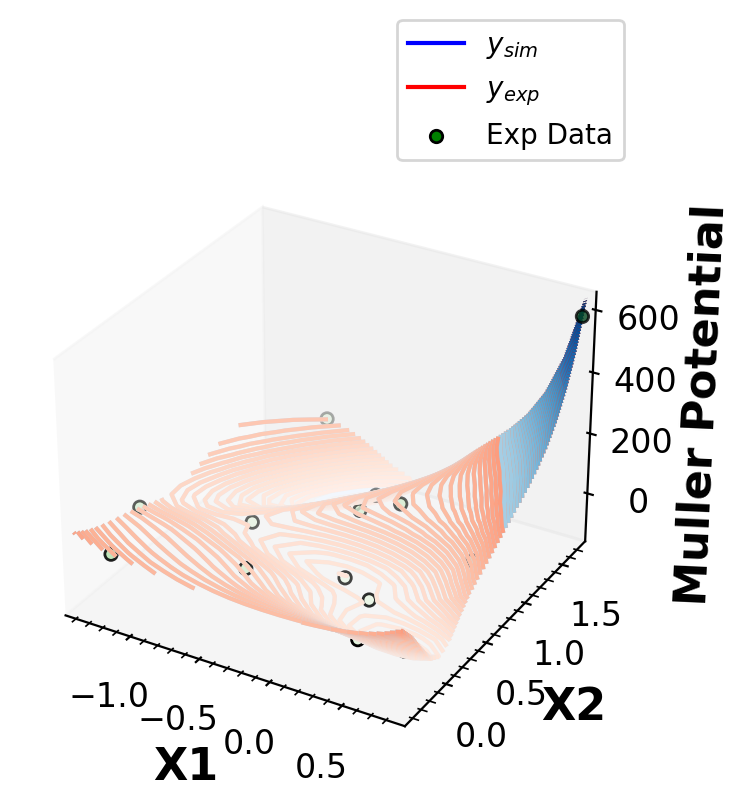

In [8]:
#New Cell
X_pred = np.array(np.meshgrid(x1,x2))
Y_pred = model(a_model, Constants, X_pred, skip_params)


# create plot and compare predictions and experiments
fig = plt.figure(figsize = (6.4,4))
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Y_pred, 100, cmap='Blues')
ax.contour3D(X1, X2, Y, 100, cmap='Reds')
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens', edgecolors = "k")
ax.plot(1000,1000,1000, label = "$y_{sim}$", color = 'blue')
ax.plot(1000,1000,1000, label = "$y_{exp}$", color = 'red')
ax.scatter(1000,1000,1000, label = "Exp Data", color = 'green', edgecolors = "k")
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.0, 1, 0.2),borderaxespad=0, loc = "lower right")

ax.minorticks_on() # turn on minor ticks
ax.tick_params(direction="in",top=True, right=True) 
ax.tick_params(which="minor",direction="in",top=True, right=True)

ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='z', nbins=5)

ax.zaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.grid(False)

ax.set_xlim((np.amin(X1),np.amax(X1)))
ax.set_zlim(np.amin(Y),np.amax(Y))
ax.set_xlim(np.amin(X1),np.amax(X1))
ax.set_ylim(np.amin(X2),np.amax(X2))
ax.set_xlabel('X1', fontsize=16,fontweight='bold')
ax.set_ylabel('X2', fontsize=16,fontweight='bold')
ax.set_zlabel('Muller Potential', fontsize=16,fontweight='bold')
ax.zaxis._axinfo['label']['space_factor'] = 2
# plt.title("Predictions vs Synthetic Data")
plt.show()

# plt.savefig("Figures/sim_true_comp.png",dpi=300)
# plt.show()

SSE =  4.878342213404024e-10


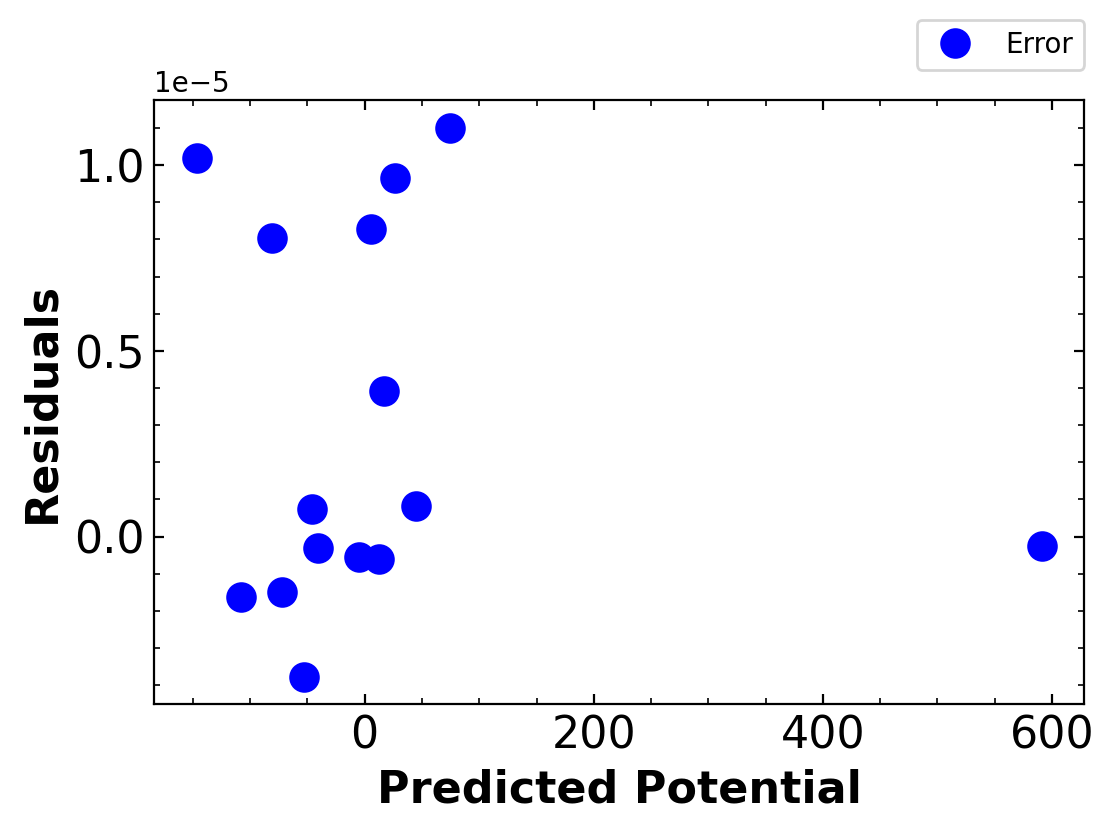

In [9]:
#Plot error
Y_pred_of_exp = model(a_model, Constants, Xexp, skip_params)
error = (Yexp - Y_pred_of_exp)
print("SSE = ", np.sum(error**2))
plt.plot(Y_pred_of_exp,error,"b.",markersize=20, label = "Error")

plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0, loc = "lower right")

plt.minorticks_on() # turn on minor ticks
plt.tick_params(direction="in",top=True, right=True) 
plt.tick_params(which="minor",direction="in",top=True, right=True)

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)

# plt.title("Residuals")
plt.xlabel('Predicted Potential', fontsize=16,fontweight='bold')
plt.ylabel('Residuals', fontsize=16,fontweight='bold')
plt.show()

/tmp/ipykernel_1988185/2025136095.py:59: RuntimeWarning: overflow encountered in exp
  y_model[i] = np.sum(A*np.exp(Term1 + Term2 + Term3) )
/tmp/ipykernel_1988185/582764105.py:27: RuntimeWarning: overflow encountered in square
  sse[i,j] = sum((y - model(a_guess_local, Constants, x, skip_params))**2)


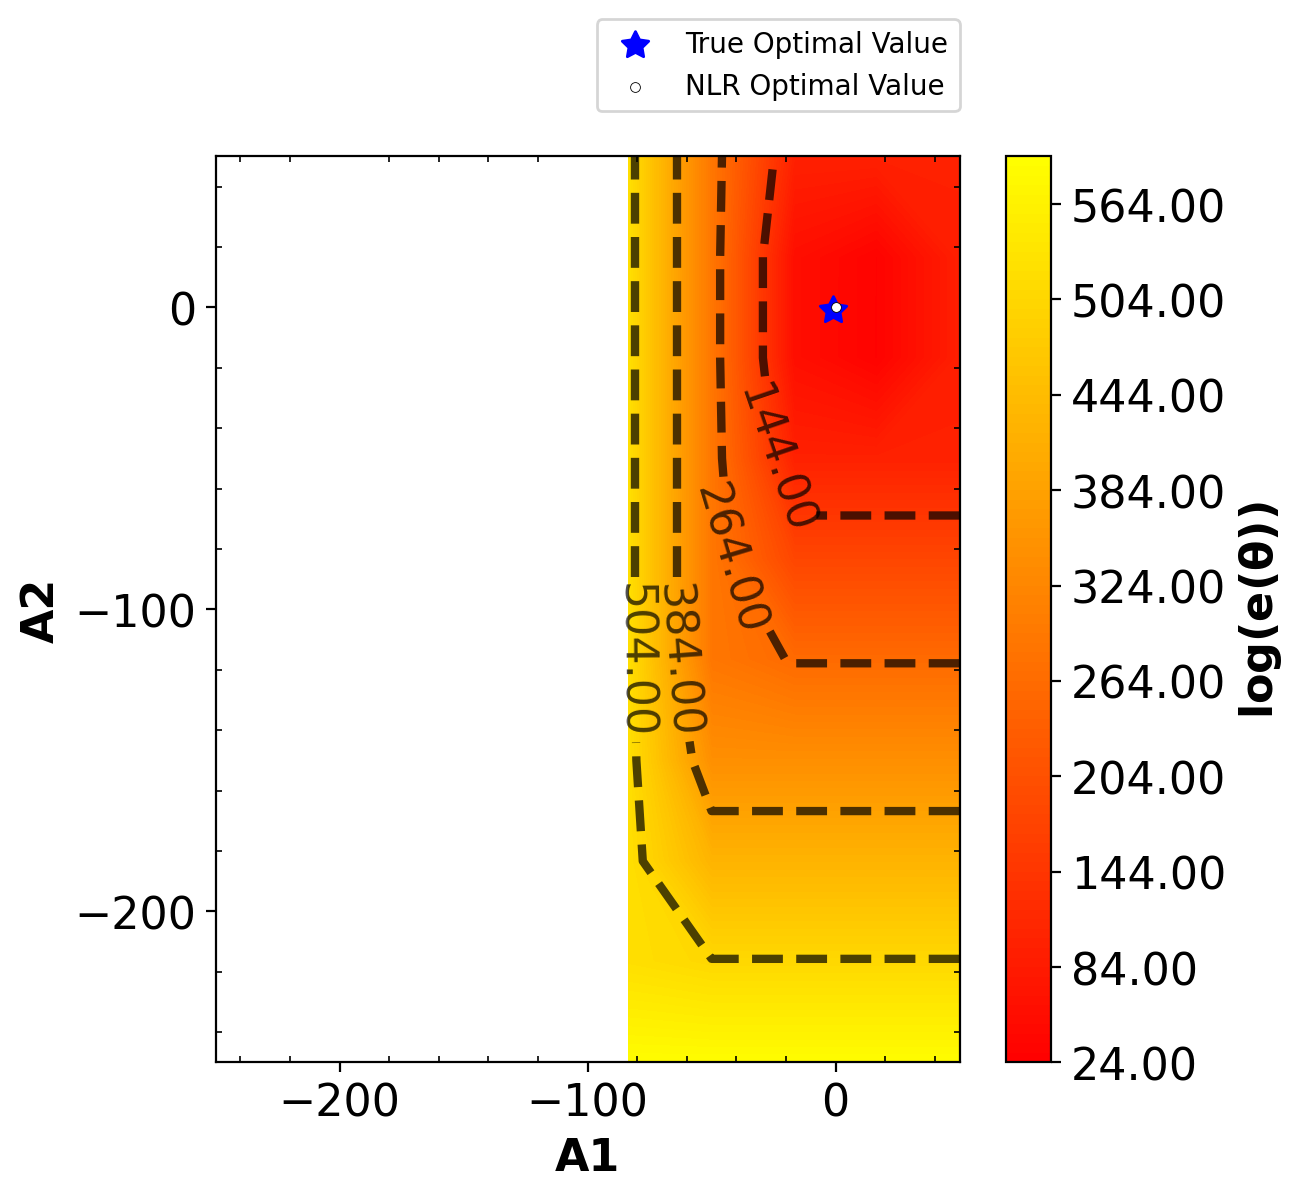

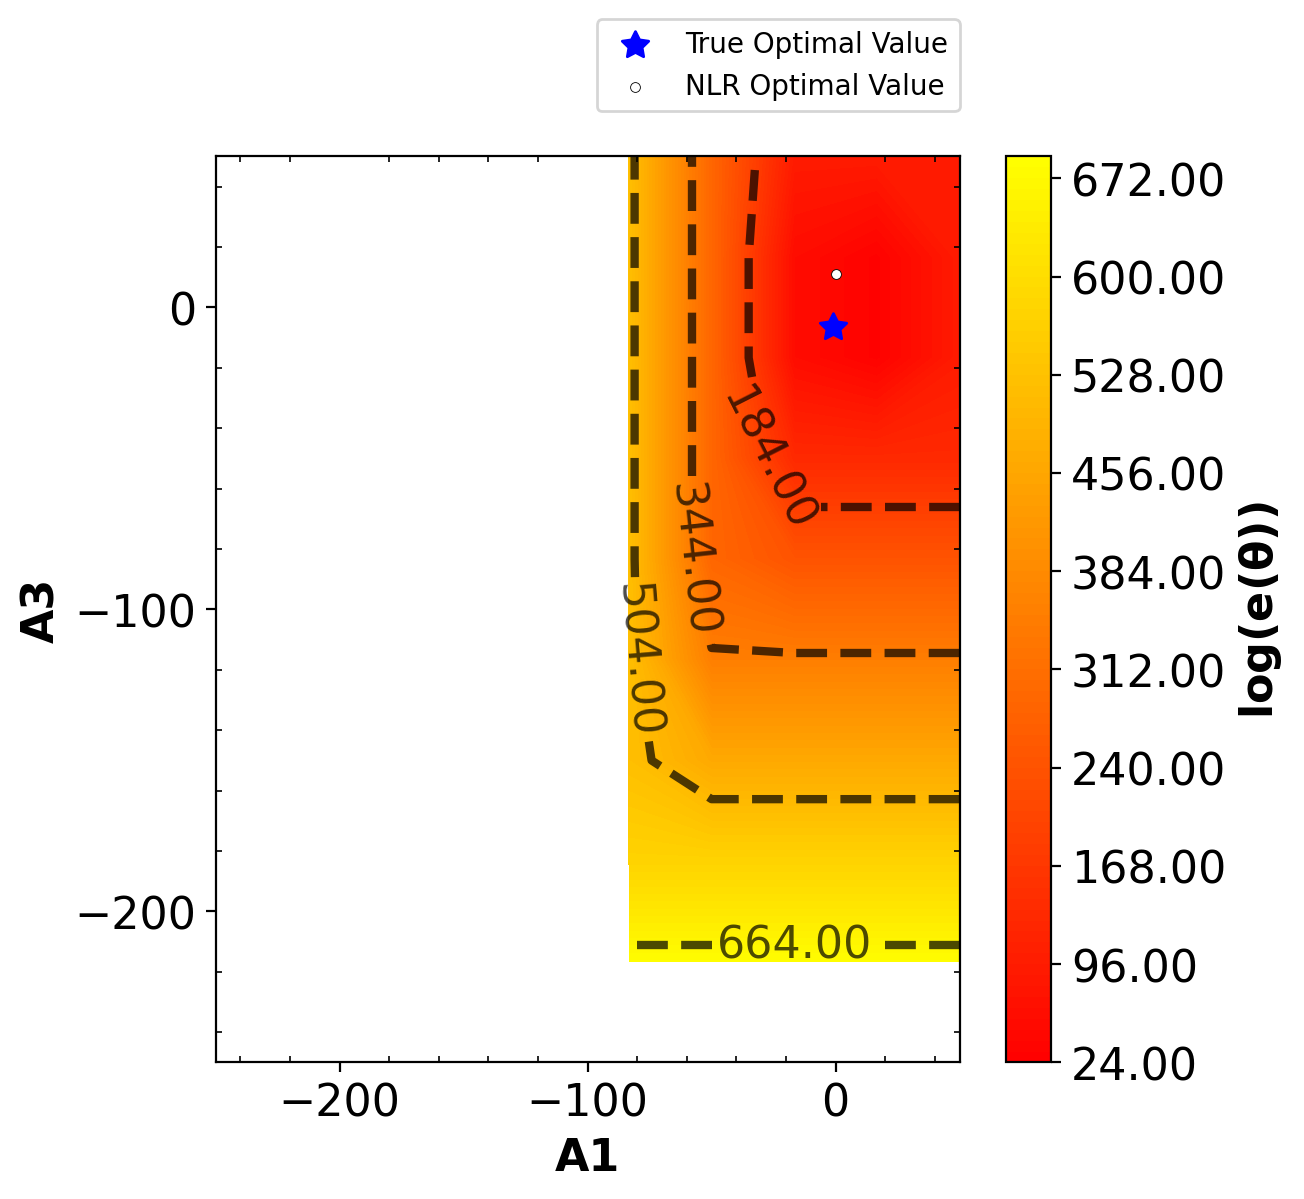

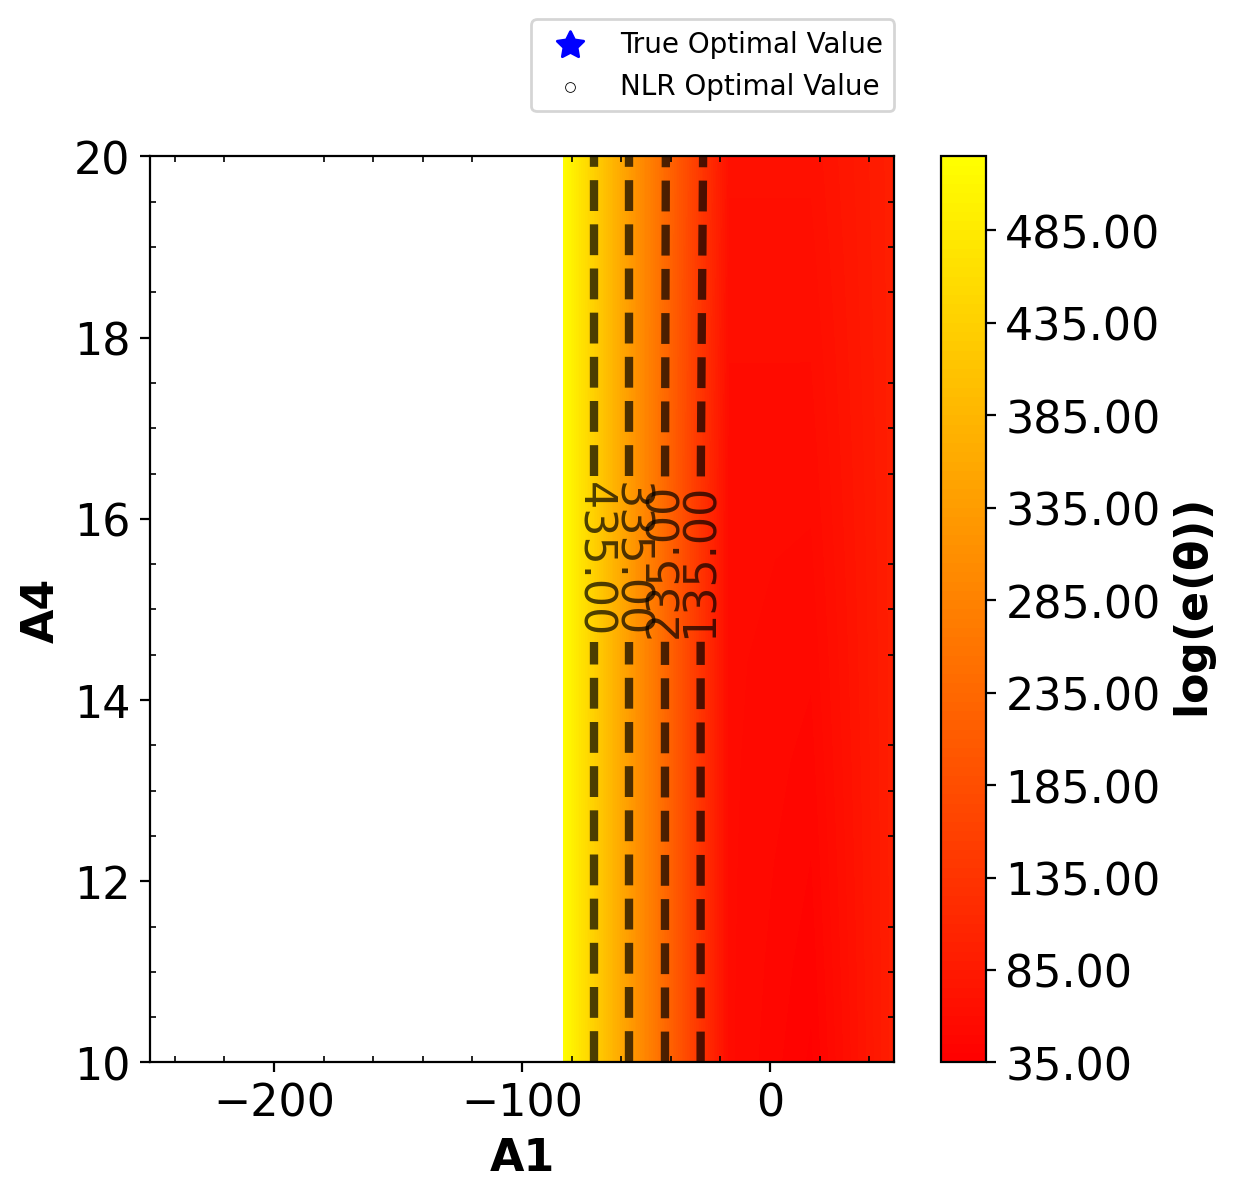

IndexError: index 8 is out of bounds for axis 0 with size 8

In [19]:
#New Cell
log_plot = True

# generate predictions
X_pred = np.array(X_mesh)
Y_pred = model(a_guess, Constants, X_pred, skip_params)
Constants_2 = Constants.flatten()

#Modify these to have less parameters
#Generate Guesses for a1-a4
a1_lin = a2_lin = np.linspace(-2,0,10)
a3_lin = np.linspace(-10,2,10)
a4_lin = b1_lin = b2_lin = b4_lin = c4_lin = np.linspace(-2,2,10)
A1_lin = A2_lin = A3_lin = np.linspace(-250,50,10)
A4_lin = np.linspace(10,20,10)
b3_lin = np.linspace(8,12,10)
b4_lin = np.linspace(-2,2,10)
c1_lin = np.linspace(-12,-8,10)
c2_lin = np.linspace(-12,-8,10)
c3_lin = np.linspace(-10,-6,10)

x0_1_lin = x0_2_lin = x0_3_lin = x0_4_lin = np.linspace(-2,2,10)
y0_1_lin = y0_2_lin = y0_3_lin = y0_4_lin = np.linspace(-2,2,10)

# param_dict = {0: "A1", 1: "A2", 2: "A3", 3: "A4",
#               4: "a1", 5: "a2", 6: "a3", 7: "a4",
#               8: "b1", 9: "b2", 10:"b3", 11:"b4",
#               12:"c1", 13:"c2", 14:"c3", 15:"c4",
#               16:"x0_1", 17:"x0_2", 18:"x0_3", 19:"x0_4",
#               20:"y0_1", 21:"y0_2", 22:"y0_3", 23:"y0_4"}

# param_dict_vals = {0: A1_lin, 1: A2_lin, 2: A3_lin, 3: A4_lin,
#               4: a1_lin, 5: a2_lin, 6: a3_lin, 7: a4_lin,
#               8: b1_lin, 9: b2_lin, 10:b3_lin, 11:b4_lin,
#               12:c1_lin, 13:c2_lin, 14:c3_lin, 15:c4_lin,
#               16:x0_1_lin, 17:x0_2_lin, 18:x0_3_lin, 19:x0_4_lin,
#               20:y0_1_lin, 21:y0_2_lin, 22:y0_3_lin, 23:y0_4_lin}

# param_dict = {0: "A1", 1: "A2", 2: "A3", 3: "A4",
#               4: "a1", 5: "a2", 6: "a3", 7: "a4",
#               8: "b1", 9: "b2", 10:"b3", 11:"b4",
#               12:"c1", 13:"c2", 14:"c3", 15:"c4",
#               16:"x0_1", 17:"x0_2", 18:"x0_3", 19:"x0_4"}

# param_dict_vals = {0: A1_lin, 1: A2_lin, 2: A3_lin, 3: A4_lin,
#               4: a1_lin, 5: a2_lin, 6: a3_lin, 7: a4_lin,
#               8: b1_lin, 9: b2_lin, 10:b3_lin, 11:b4_lin,
#               12:c1_lin, 13:c2_lin, 14:c3_lin, 15:c4_lin,
#               16:x0_1_lin, 17:x0_2_lin, 18:x0_3_lin, 19:x0_4_lin}

param_dict = {0: "A1", 1: "A2", 2: "A3", 3: "A4",
              4: "a1", 5: "a2", 6: "a3", 7: "a4",
              8: "b1", 9: "b2", 10:"b3", 11:"b4",
              12:"c1", 13:"c2", 14:"c3", 15:"c4",
              16:"x0_1", 17:"x0_2", 18:"x0_3", 19:"x0_4"}

param_dict_vals = {0: A1_lin, 1: A2_lin, 2: A3_lin, 3: A4_lin,
              4: a1_lin, 5: a2_lin, 6: a3_lin, 7: a4_lin,
              8: b1_lin, 9: b2_lin, 10:b3_lin, 11:b4_lin,
              12:c1_lin, 13:c2_lin, 14:c3_lin, 15:c4_lin,
              16:x0_1_lin, 17:x0_2_lin, 18:x0_3_lin, 19:x0_4_lin}

dim_list = np.linspace(0,d-1,d)
mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)
#     print(mesh_combos)
#Loop over combinations of axes and create heatmaps
for i in range(len(mesh_combos)):
    indecies = mesh_combos[i]
    param_vals_list = [ param_dict_vals[indecies[0]], param_dict_vals[indecies[1]] ]
    
    P1_vals, P2_vals = param_vals_list[0], param_vals_list[1]
    theta_mesh = np.array(np.meshgrid(P1_vals, P2_vals))
#     print(theta_mesh)
    zz = sse_func(a_model, Xexp, Yexp, theta_mesh, indecies, skip_params)

    if log_plot == True:
        zz = np.log(zz)
    #Better way to do this?
    plt.figure(figsize = (6,6))

    plt.contourf(P1_vals,P2_vals, zz, cmap = "autumn", levels = 100)
#             plt.colorbar()

    cs = plt.contourf(P1_vals,P2_vals, zz, cmap = "autumn", levels = 100)
            # plot color bar
    if np.amax(zz) < 1e-1:
        cbar = plt.colorbar(cs, format='%.2e')
    else:
        cbar = plt.colorbar(cs, format = '%2.2f')

        # plot title in color bar
        cbar.ax.set_ylabel(r'$\mathbf{log(e(\theta))}$', fontsize=16, fontweight='bold')
    #     print(p_GP_opt[0],p_GP_opt[1])

        # set font size in color bar
        cbar.ax.tick_params(labelsize=16)

        # Plot equipotential line
        cs2 = plt.contour(cs, levels=cs.levels[::20], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

        #Plot heatmap label

        if np.amax(zz) < 1e-1:
            plt.clabel(cs2, fmt='%.2e', colors='k', fontsize=16)
        else:
            plt.clabel(cs2, fmt='%2.2f', colors='k', fontsize=16)

        plt.axis()
        
#         print(Constants_2[indecies[0]+4*skip_params])
        plt.scatter(Constants_2[indecies[0]+4*skip_params],Constants_2[indecies[1]+4*skip_params], color="blue", s=100, 
                    label = "True Optimal Value", marker = (5,1)) #k +1 since we chose a&b
        plt.scatter(a_model[indecies[0]+4*skip_params],a_model[indecies[1]+4*skip_params], color="white",s=50, 
                    marker = ".", edgecolors= "k", linewidth=0.3, label = "NLR Optimal Value")
#         print(a_model[indecies[0]+4*skip_params], Constants_2[indecies[0]+4*skip_params])
#         print(a_model[indecies[1]+4*skip_params], Constants_2[indecies[1]+4*skip_params])
        # plt.grid()
        plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0, loc = "lower right")
        plt.xlabel(param_dict[indecies[0]],fontsize=16,fontweight='bold')
        plt.ylabel(param_dict[indecies[1]],fontsize=16,fontweight='bold')

        plt.xlim((np.amin(P1_vals), np.amax(P1_vals)))
        plt.ylim((np.amin(P2_vals), np.amax(P2_vals)))

        plt.minorticks_on() # turn on minor ticks
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tick_params(which="minor",direction="in",top=True, right=True)
        plt.locator_params(axis='y', nbins=5)
        plt.locator_params(axis='x', nbins=5)

#             if log_plot == True:
#                 plt.title('NLR ln(SSE)', weight='bold',fontsize = 16)
#     #             plt.savefig("Figures/NLR_ln(SSE).png",dpi=300)
#             else:
#                 plt.title('Non-Linear Regression SSE', weight='bold',fontsize = 16)
#     #             plt.savefig("Figures/NLR_SSE.png",dpi=300)

        plt.show()

In [22]:
#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
Jacobian = Solution.jac
print(Jacobian) #Jacobian is fine for simple cases
#Normalize Jacobian
# print("Normalized Jacobian =\n")
# for i in range(len(a_model)):
#     Jacobian[i,:] = Jacobian[i,:]*a_model
# print(Jacobian)

#OR normalize error instead of FIM to solve the problem (2 ways to do this)
# error_normalized = (error - np.average(error)) / np.average(error)
# error_normalized = (error - np.amin(error)) / (np.amax(error)- np.amin(error))
# print("Normalized Error =  \n", error_normalized)

sigre = (error.T @ error)/(len(error) - 2)
# sigre = (error_normalized.T @ error_normalized)/(len(error_normalized) - 2)
# Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
Sigma_theta2 = sigre * np.linalg.inv(Jacobian.T @ Jacobian)
print("Covariance matrix:\n",Sigma_theta2)

Jacobian =

[[ 1.21824711e-02  7.21029490e-01  1.63329469e-01 -1.36788514e+01
  -9.28807259e-03 -1.41942716e+00 -3.30608018e-01  1.25355983e+00]
 [ 1.25775973e+00  4.71591774e-03  1.08278651e-04 -1.70103836e+00
   2.59870529e-01  3.86905670e-03  3.23382224e-04 -1.62941952e+01]
 [ 1.54946312e+00  1.56951343e+01  8.33932064e+00 -5.49502850e+00
  -1.72968864e-01  2.51344061e+00  1.10307086e+01 -9.33531499e+00]
 [-0.00000000e+00  3.57627735e-06  1.40457284e+00 -2.81584263e-02
   0.00000000e+00 -4.52995300e-06 -8.16716394e-01 -6.21590137e-01]
 [ 2.03422495e-01  2.60885580e+01 -0.00000000e+00 -2.87636001e+02
  -5.07819653e-01  4.93755579e+00  0.00000000e+00  5.92829227e+01]
 [-0.00000000e+00  7.62939169e-06  3.37512478e-02 -2.08812372e+03
   0.00000000e+00  7.62939453e-06  5.72065756e-03 -8.15472473e+02]
 [ 4.64775425e+01  2.40752989e+00 -0.00000000e+00 -6.33204293e+00
  -1.31082106e+00  2.19745588e+00  3.68465001e-07  1.21620417e+01]
 [ 1.10506983e-03  8.08238682e-05  1.91229745e-01 -3.1712

In [23]:
import scipy.linalg as linalg
val, vec = linalg.eig(Sigma_theta2)
print("Eigenvalues = \n",val)
print("Eigenvectors = \n",vec)

Eigenvalues = 
 [2.56057942e-12+0.j 6.23568208e-13+0.j 3.09396097e-13+0.j
 1.59651720e-13+0.j 2.44491760e-14+0.j 1.16592450e-14+0.j
 4.79382050e-16+0.j 7.33789382e-18+0.j]
Eigenvectors = 
 [[ 1.82694222e-03 -2.63924444e-02 -4.40432661e-02  3.73004786e-02
   2.12346358e-01  9.63796270e-01 -1.48231663e-01 -1.45392403e-03]
 [ 2.46434935e-02 -5.09532072e-02 -2.40656754e-01  1.55755858e-02
   9.39286149e-01 -2.29408342e-01 -6.12337880e-02 -1.40116577e-03]
 [ 7.91648634e-01  8.26501470e-02  5.75252170e-01  1.38929544e-01
   1.27299195e-01 -6.28446847e-03  5.78401828e-04 -3.67042120e-05]
 [ 5.98402082e-04 -3.64001618e-03 -8.42132698e-03  4.47160484e-03
   3.28192212e-02  4.65813634e-02  3.44978752e-01  9.36823470e-01]
 [ 1.91616926e-02  8.73449391e-02 -2.52397246e-01  9.59387446e-01
  -8.37471010e-02 -2.87589187e-02 -5.86489619e-03  2.51717898e-06]
 [-8.94164571e-02 -9.58719863e-01  2.24931037e-01  1.47565293e-01
  -3.78759162e-05 -2.19664286e-02 -2.98055574e-03 -1.59247759e-04]
 [-6.03586603

In [24]:
FIM = (1/sigre) * Jacobian.T @ Jacobian
print("FIM = \n", FIM)

FIM = 
 [[ 1.27654729e+14  8.44620569e+12  3.62183295e+11 -2.88155652e+14
  -1.03527641e+12 -8.20001115e+11  5.04211448e+11  2.05860066e+14]
 [ 8.44620569e+12  4.88816153e+13  4.51432133e+12 -2.22600005e+14
  -1.61988795e+12  7.58804928e+11  7.41810674e+12  5.05115175e+13]
 [ 3.62183295e+11  4.51432133e+12  2.11323141e+12 -4.13605529e+12
  -4.45442333e+10  4.00746523e+11  2.38780651e+12 -3.20251854e+12]
 [-2.88155652e+14 -2.22600005e+14 -4.13605529e+12  1.19852047e+17
  -4.09328214e+12 -2.25601728e+13 -1.01242306e+12  4.39921743e+16]
 [-1.03527641e+12 -1.61988795e+12 -4.45442333e+10 -4.09328214e+12
   6.41303273e+12  6.59027395e+11 -6.73921673e+10  1.19327406e+13]
 [-8.20001115e+11  7.58804928e+11  4.00746523e+11 -2.25601728e+13
   6.59027395e+11  1.84042123e+12  3.41841435e+11 -1.62101694e+12]
 [ 5.04211448e+11  7.41810674e+12  2.38780651e+12 -1.01242306e+12
  -6.73921673e+10  3.41841435e+11  3.77895018e+12 -2.45843559e+12]
 [ 2.05860066e+14  5.05115175e+13 -3.20251854e+12  4.39921743

In [25]:
print(np.linalg.det(FIM))
print(np.linalg.det(Sigma_theta2))
print(sigre)

1.2644495485489964e+109
7.908579675223178e-110
3.752570933387712e-11


In [26]:
Test = Jacobian.T @ Jacobian
print(np.linalg.det(Test))
print(Test)
val, vec = linalg.eig(Test)
print(val)

4.972019096923988e+25
[[ 4.79033425e+03  3.16949860e+02  1.35911851e+01 -1.08132452e+04
  -3.88494817e+01 -3.07711235e+01  1.89208922e+01  7.72504499e+03]
 [ 3.16949860e+02  1.83431729e+03  1.69403110e+02 -8.35322307e+03
  -6.07874443e+01  2.84746932e+01  2.78369717e+02  1.89548052e+03]
 [ 1.35911851e+01  1.69403110e+02  7.93005077e+01 -1.55208409e+02
  -1.67155395e+00  1.50382975e+01  8.96041331e+01 -1.20176780e+02]
 [-1.08132452e+04 -8.35322307e+03 -1.55208409e+02  4.49753308e+06
  -1.53603316e+02 -8.46586485e+02 -3.79918936e+01  1.65083754e+06]
 [-3.88494817e+01 -6.07874443e+01 -1.67155395e+00 -1.53603316e+02
   2.40653602e+02  2.47304705e+01 -2.52893888e+00  4.47784557e+02]
 [-3.07711235e+01  2.84746932e+01  1.50382975e+01 -8.46586485e+02
   2.47304705e+01  6.90631121e+01  1.28278423e+01 -6.08298107e+01]
 [ 1.89208922e+01  2.78369717e+02  8.96041331e+01 -3.79918936e+01
  -2.52893888e+00  1.28278423e+01  1.41807786e+02 -9.22545394e+01]
 [ 7.72504499e+03  1.89548052e+03 -1.20176780e+